# Naive Bayes models and handwritten digit recognition (MNIST)

Homework

- Recreate Bernoulli NB from scratch (using numpy)
   - compute class log priors 
   - compute class log conditional feature probabilities 
   - predict on a new example

## Load all needed packages

In [2]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots

## Load the training/test data

In [3]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
print(Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


## Problem 1: Prepare data for Bernoulli NB model (2 points)
- flatten 28x28 images into 784 length vector
- convert 0-255 scale image values into 0,1

In [4]:
# copy lines from classwork notebook to create Xtrainf_ber and Xtestf_ber
Xtrainf = Xtrain.reshape((60000,784))
Xtetsf = Xtest.reshape((10000,784))
func_vect = np.vectorize(lambda x: 1 if x>0 else x)
Xtrainf_ber = func_vect(Xtrainf)
Xtestf_ber = func_vect(Xtetsf)

## Reconstruct BernoulliNB using numpy
- learn prior probabilities using ytrain and smoothing constant alpha
- learn class conditional feature densities using Xtrainf_ber (bernoulli version) and ytrain and smoothing alpha

## Problem 2: Learn the class prior (3 points)

In [5]:
def build_log_prior_probabilities(ytrain,alpha):
    # 3 or fewer lines of code expected
    #learn P(digit) for every digit
    ytrain = np.apply_along_axis((lambda x: x+alpha), axis = 0, arr = ytrain)
    counts = np.unique(ytrain, return_counts = True)[1]
    return np.log(np.apply_along_axis((lambda x: x/ytrain.size), axis = 0, arr = counts))
    

## Problem 3: Test the prior building function (1 point)

In [6]:
# run this cell after implementing cell above. Print log_prior.
log_prior = build_log_prior_probabilities(ytrain,1.0)
print(log_prior)

[-2.31550148 -2.18598795 -2.30960971 -2.28098669 -2.32927136 -2.40406426
 -2.31634601 -2.25936597 -2.32773198 -2.31112142]


## Problem 4: How close are the probability estimates? (4 points)
- (2 points) compare log_prior computed by you and classifier.class_log_prior_ computedby sklearn
- (2 points) decide on a good way to present the comparison

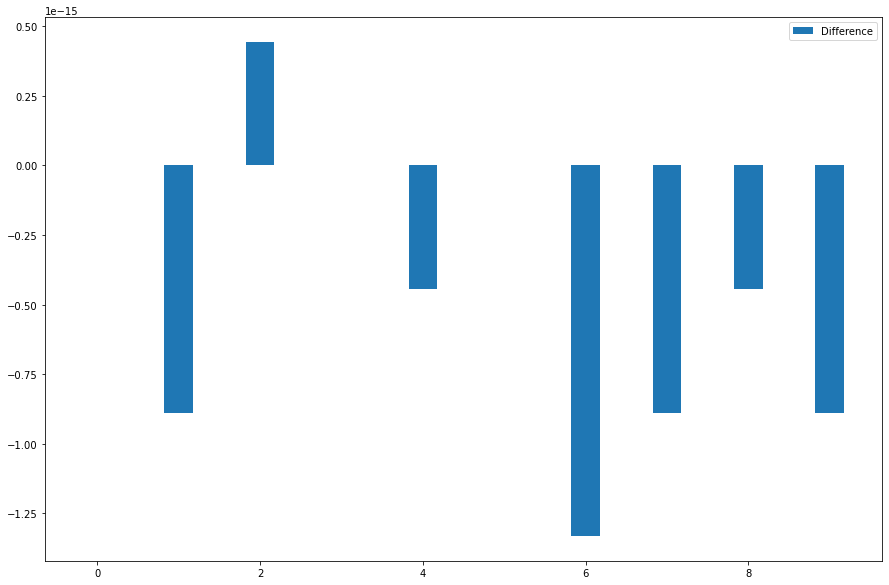

In [7]:
# comparing your prior computation with sklearn's
# rebuild sklearn's model from your classwork notebook 
clf = BernoulliNB(alpha = 1)
clf.fit(Xtrainf_ber,ytrain)
# 2-3 lines of code expected
plt.bar([i for i in range(0,10)], np.subtract(clf.class_log_prior_, log_prior), 0.35, label = "Difference")
plt.legend()

We get very small differences in probabilities because every difference should be multiplied by 10^(-15). 10^(-15) is effectively 0. 

## Problem 5: Learn the class conditional feature probabilities (8 points)
- for each class, for each pixel, get counts of the value 1 for that pixel
- smooth counts for each (class,pixel) pair
- return log of the normalized counts

In [8]:
def build_class_conditional_feature_probabilities(Xtrain,ytrain,alpha):
    # 7-8 lines expected
    
    #Let's make np array with number
    #digits = np.array(range(0, 10)).reshape(1,10);
    x_res = np.zeros((10,784))
    for digit in range(10):
        digit_indices = np.where(ytrain == digit)[0]
        x_digit = Xtrain[digit_indices, :]
        x_res[digit, :] = np.apply_along_axis(sum, axis = 0, arr = x_digit) + alpha
        x_res[digit, :] = x_res[digit, :]/(len(digit_indices) + 2*alpha)
    return np.log(x_res)
        #get indices of digit

## Problem 6: test the class conditional feature probabilities function (2 points)

In [9]:
# run this cell after you have implemented the function above
log_feature_probabilities = build_class_conditional_feature_probabilities(Xtrainf_ber,ytrain,1.0)

## Problem 7: Visualize the class conditional feature probabilities (2 points)
- use visualize_images() from the classwork notebook

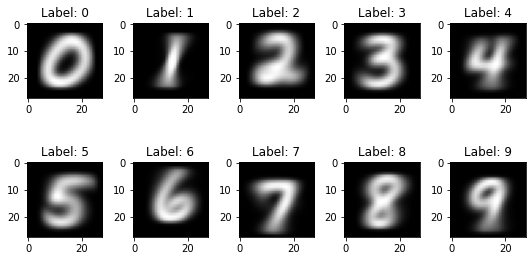

In [10]:
# viz code here (1 line of code expected)
def visualize_images(X,y):
    num_row = 2
    num_col = 5
    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(X[i], cmap='gray')
        ax.set_title('Label: {}'.format(y[i]))
    plt.tight_layout()
    plt.show()
visualize_images(np.exp(log_feature_probabilities).reshape((10,28,28)), [i for i in range(0, 10)])

## Problem 8: How close are your class conditional probability estimates? (4 points)
- compare P(pixel(i,j) = 1|digit = d) computed by you using np, and that computed by sklearn
- compute the difference between these probabilities
- visualize the probability differences using visualize_image

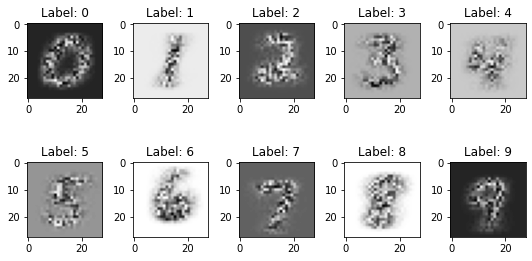

In [15]:
# use the sklearn computed log_feature_probabilities
# viz code (3 lines of code expected)
dif_arr = np.subtract(np.exp(log_feature_probabilities), np.exp(clf.feature_log_prob_))
visualize_images(dif_arr.reshape((10,28,28)), [i for i in range(0, 10)])

The diference is very small. Therefore, one images cover the others almost prefectly.

## Problem 9: The prediction function for your NB classifier implementation (6 points)
- use Bayes rule and the prior and class conditional densities to compute the posterior probability P(digit=d|image)
- remember to do the calculation in log space
- vectorize this computation -- do not use a for loop! hint: use element-wise product *
- pick the digit d with the highest log posterior probability as the predicted label

In [12]:
def predict(image_vector,log_prior,log_feature_probabilities):
    # 3 lines of code expcted
    #let's get P(image|digit=d)
    #Assume image_vector has unique images
    #Get the prbabilities of pixels that appear and probabilities of pizels that do not appear
    image_pixels_in = log_feature_probabilities*image_vector #nullifies pixel probs that are not there
    #P(image|digit) = P(pixels that are to appear|digit)*P(pixels that are black not to appear|digit)
    #log(1 - exp(log_feat)) * (1 - image_vect)
    image_pixels_out = np.log(1-np.exp(log_feature_probabilities))*(1-image_vector)
    return np.argmax(np.apply_along_axis(sum, axis = 1, arr = image_pixels_in + image_pixels_out) + log_prior)

## Problem 10: Evaluate performance of classifier on test set (4 points)
- use classifier to predict labels of images in Xtestf_ber with your prediction function
- compare predicted labels with actual labels using sklearn.metrics functions
   - accuracy_score()
   - f1_score()
   - confusion_matrix()
   - classification_report()

In [13]:
# run your predict function on image vectors in Xtestf_ber and place your predictions in array ypred
# 1-2 lines of code expected
y_pred = np.array([predict(Xtestf_ber[vector,:], log_prior, log_feature_probabilities) for vector in range(Xtestf_ber.shape[0])])

In [14]:
# use sklearn's metric functions to evaluate accuracy, F1, confusion_matrix and classification report
# 4 lines of code expected
print("Accuracy: ", metrics.accuracy_score(ytest, y_pred))
print("F1-score: ", metrics.f1_score(ytest, y_pred, average = 'macro'))
print("Confusion matrix:\n", metrics.confusion_matrix(ytest, y_pred))
print("Classification report:\n", metrics.classification_report(ytest, y_pred))

Accuracy:  0.8413
F1-score:  0.8392391663847404
Confusion matrix:
 [[ 887    0    4    7    2   41   16    1   22    0]
 [   0 1085   10    5    0    9    6    0   19    1]
 [  19    8  852   29   17    4   32   14   55    2]
 [   5   15   34  844    0   13    9   15   49   26]
 [   2    6    4    0  795    4   21    1   23  126]
 [  23   12    7  129   30  627   16    8   21   19]
 [  18   18   15    2   13   35  851    0    6    0]
 [   1   24   14    4   15    0    0  871   27   72]
 [  16   23   13   76   17   22    7    6  758   36]
 [   9   13    5    9   74    8    0   24   24  843]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       980
           1       0.90      0.96      0.93      1135
           2       0.89      0.83      0.86      1032
           3       0.76      0.84      0.80      1010
           4       0.83      0.81      0.82       982
           5       0.82      0.70      0.76       892